<div align="center" style="line-height: 1.7;">
    <h2 style="font-weight: 600;"><strong>Q-Learning in GridWorld</strong></h2>
</div> 

&nbsp;

**Goal:** Learn an optimal **policy** $\pi(s)$ that maximizes expected long-term reward, called **return**, by interacting with a stochastic GridWorld.  


**Why Q-Learning?**  
Q-Learning is one of the most widely used **off-policy, model-free reinforcement learning algorithms.** It allows an agent to learn how to act optimally in an environment **purely through experience**, without knowing the transition dynamics in advance

At each step, the agent:

1. Observes the **current state** s
2. Chooses an **action** a
3. Receives a **reward** r
4. Transitions to a **new state** s'
5. Updates its belief about how good that action was.

---

The **return** is defined as the discounted sum of **future rewards**.
    
$$
G_t = \sum_{k=0}^{\infty} \gamma^{k}\, r_{t+k+1}
$$

where $\gamma \in[0, 1]$ is the **discount factor**, controlling how much future rewards matter compared to immediate ones.

---

## The Action-Value Function
Instead of directly estimating the value of each state, Q-Learning estimates the **action-value function**, or **Q-function**.

$
Q(s, a) = $ expected return if the agent starts at state s, takes action a, and thereafter follows the **optimal policy**.

If we knew $Q(s, a)$ exactly, the best action in any state would simply be:

$$
\pi^{*}(s) = \arg\max_{a'} \, Q^{*}(s, a)
$$

---

## The Bellman Optimality Equation (off-policy)
The Q-function obeys a recursive relationship known as the **Bellman optimality equation**:

$$
Q^{*}(s, a) = \mathbb{E} \Big[\, r + \gamma \max_{a'} Q^{*}(s', a') \,\Big]
$$

This means:
* The value of doing action $a$ in state $s$ equals the **expected immediate reward** $r$ plus the **discounted value** of the best possible future action in the next state $s'$.
* The equation is **self-referential**, each $Q$ depends on other $Q$ values, which is what allows iterative updates to converge toward the optimal $Q^{*}$.

---

## The Q-Learning Update Rule
Usually the true expectation $\mathbb{E} \Big[\cdot \Big]$,  
Q-Learning uses **sample-based updates** during interaction with the environment.

$$
Q(s, a) \leftarrow Q(s, a) + \alpha [r + \gamma \max_{a'} Q(s', a') - Q(s, a)]
$$

**Symbols**

| **Symbol** | **Meaning** |
|:-----------:|:------------|
| $( s )$ | Current state |
| $( a )$ | Action taken in state $( s )$ |
| $( r )$ | Immediate reward received after taking $( a )$ |
| $( s' )$ | Next state observed after taking $( a )$ |
| $( \alpha \in (0,1] )$ | Learning rate — controls how fast old information is replaced by new |
| $( \gamma \in [0,1] )$ | Discount factor — determines how much future rewards matter |
| $( \max_{a'} Q(s', a') )$ | Estimate of the best possible future value at the next state |
| $( r + \gamma \max_{a'} Q(s', a') - Q(s, a) )$ | Temporal-Difference (TD) error — how “surprised” we are by the new outcome |

$\newline$

The TD error measures the difference between:
* What we **expected** from our current estimate $Q(s, a)$, and
* What we **actually observed** after one step of interaction
  
By repeatedly applying this update as the agent explores the environment, the Q-table gradually converges toward $Q^{*}(s, a)$.

---

### Exploration vs Exploitation (off-policy)
To lean effectively, the agent must balance **exploration** (trying new actions to gather information) and **exploitation** (choosing the best known action).

A common stratey is the **ε-greedy policy**, the agent selects actions as follows:

$$
a =
\begin{cases}
\text{a random action}, & \text{with probability } \varepsilon \\
\arg\max_{a} Q(s, a), & \text{with probability } 1 - \varepsilon
\end{cases}
$$

* $\varepsilon$ starts large (e.g., 1.0) and decays gradually as training progresses.
* This ensures that early on the agent explores widely, and later focuses on exploitation once the environment is well understood.

---

### Intuitive Summary


| **Concept** | **Analogy** |
|:-----------:|:------------|
| Q-table | A "map" where each cell tells how good a move is in a given state |
| TD Error | How much the actual outcome differed from what is predicted |
| Learning rate $\alpha$ | How quickly the old policy is corrected  |
| Discount $\gamma$ | How farsighted the agent is $(y = 0 \rightarrow \text{short-sighted}, \gamma = 1 \rightarrow \text{long-term planner})$ |
| $\varepsilon\text{-greedy}$ | Curiosity level, explore vs exploit |

$\newline$

Over many episodes, these variables let the agent **discover the optimal path** through the GridWorld, even under stochastic transition

---


## 1) Import & Environment Setup
This section imports all the necessary code and libraries. (There will be an `environment setup` in every notebook, it is necessary for the correct functioning of the algorithms and future analysis)

In [3]:
# --- Notebook Setup ----------------------------------------------------
import sys, os
from pathlib import Path
from IPython import get_ipython
import importlib
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Optional, List, Dict, Tuple
import numpy as np

GREEN = "\033[92m"; RED = "\033[91m"; RESET = "\033[0m"

try:
    root = Path.cwd()
    src_path = (root / "../src").resolve()

    # 1) Make sure local ../src wins over site-packages
    if str(src_path) not in sys.path:
        sys.path.insert(0, str(src_path))

    ip = get_ipython()
    if ip:
        ip.run_line_magic("load_ext", "autoreload")
        ip.run_line_magic("autoreload", "2")

    # 2) Import and *verify* we’re loading the right files
    import rl_capstone
    import rl_capstone.rl_algorithms as rla
    print("rl_capstone from:", getattr(rl_capstone, "__file__", "?"))
    print("rl_algorithms from:", getattr(rla, "__file__", "?"))

    # 3) Force a reload in case kernel already loaded the old one
    importlib.reload(rla)

    # 4) Now import the names (after reload)
    from rl_capstone import GridWorld, WorldSettings
    from rl_capstone.rl_algorithms import TrainConfig, q_learning_train_with_logs
    from rl_capstone.utils import (
    evaluate_policy,
    greedy_policy_from_0,
    plot_learning_curve,
    EpisodeLog,
    greedy_action,
    run_greedy_episode,
    rolling,
    idx_traj_to_rc_path,
    value_grid,
    plot_value_and_policy,
)

    print(f"{GREEN}Environment setup complete!{RESET}")

except Exception as e:
    print(f"{RED}Setup failed:{RESET}", e)


rl_capstone from: /Users/houndsito/Documents/Development/github/fcampoverdeg/reinforcement_learning/src/rl_capstone/__init__.py
rl_algorithms from: /Users/houndsito/Documents/Development/github/fcampoverdeg/reinforcement_learning/src/rl_capstone/rl_algorithms.py
Environment setup complete!


## 2) Build & Preview the environment
This section is for visualization purposes, the user can see the world where the agent will be performing its tasks, this can be changed by the user by adding walls, pits, changing the position of the starting point and the goal, as well as the size of the Grid World.

(For more information on how to use the `GridWorld` class please check: [GridWorld](../src/rl_capstone/rl_algorithms.py))


States=121, Actions=4, Grid=11x11



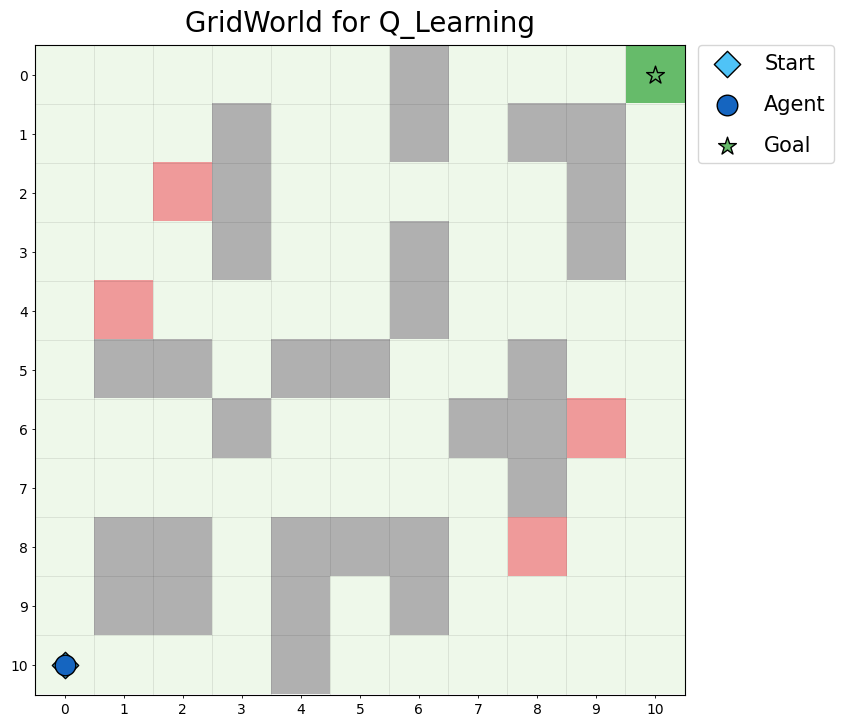

In [19]:
# Instantiate environment with your WorldSettings
settings = WorldSettings()      # Default map
env = GridWorld(settings)
env.seed(7)

print(f"\nStates={env.num_states}, Actions={env.num_actions}, Grid={env.rows}x{env.cols}\n")

env.render(title="GridWorld for Q_Learning")

## 3) Log Config

This section controls how often the log training progress is and how many episodes are run to measure greedy performance at each snapshot.

Users can change the limit of snapshots, episodes and seed, which will affect factors like: `Wind randomness`, `Transition noise`, `Length and returns of greedy evaluation episodes`.

In [9]:
# Tweak depending on user preferences
@dataclass
class LogConfig:
    snapshot_every: int = 40    # take a snapshot every N episodes
    eval_episodes: int = 5      # greedy evals per snapshot
    seed: Optional[int] = 7

print(f"{GREEN}Log Config Setup!{RESET}")

Log Config Setup!


## 4) Train Configuration Q-Learning & Plot Learning Curves

In this section the user can set up the configurations needed for training the agent. As well as visualize how the agent is learning by plotting a `Learning Curve`, which shows the number of episodes with respect to the `Return` the agent experienced in the algorithm with the respective configurations.

In [13]:
# Same constants as other models
cfg = TrainConfig(
    episodes=750,
    max_steps=1000,
    alpha=0.10,
    gamma=0.99,
    eps_start=1.0,
    eps_end=0.05,
    eps_decay_steps=10_000,
    seed=42,
    q_init=0.0
)

logcfg = LogConfig(snapshot_every=40, eval_episodes=5, seed=7)

Q, logs = q_learning_train_with_logs(env, cfg, logcfg)
print(f"{GREEN}Q_Learning Training complete.\n{RESET}")

Q_Learning Training complete.




Evaluation — mean return over 30 episodes: 0.779, mean steps: 23.1



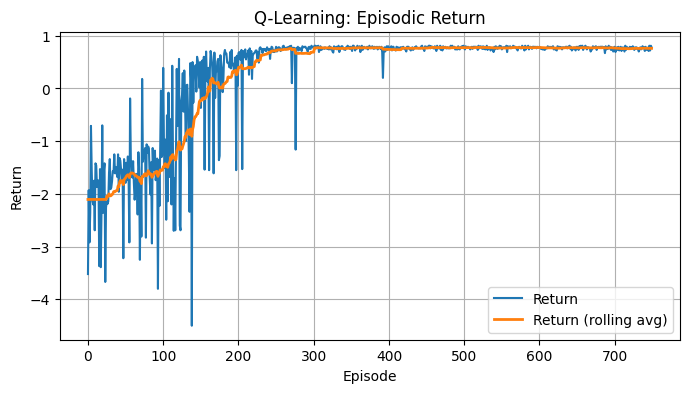

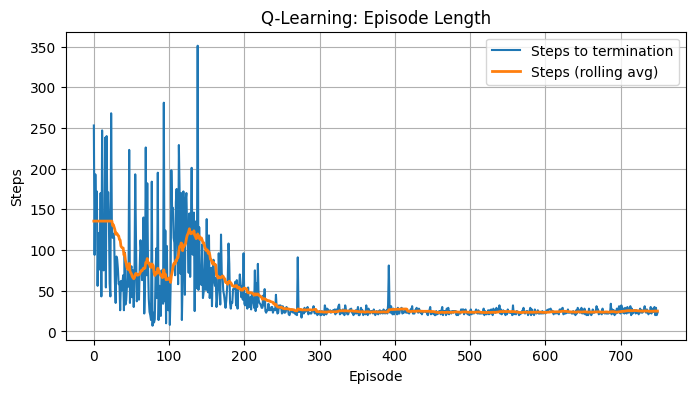

In [15]:
pi_q = greedy_policy_from_0(Q)
mean_return, mean_len = evaluate_policy(env, pi_q, episodes=30, max_steps=1000, seed=123)
print(f"\nEvaluation — mean return over 30 episodes: {mean_return:.3f}, mean steps: {mean_len:.1f}\n")


plt.figure(figsize=(8,4))
plt.plot(logs["returns"], label="Return")
plt.plot(rolling(logs["returns"], 25), label="Return (rolling avg)", linewidth=2)
plt.title("Q-Learning: Episodic Return"); plt.xlabel("Episode"); plt.ylabel("Return")
plt.grid(True); plt.legend(); plt.show()

plt.figure(figsize=(8,4))
plt.plot(logs["steps"], label="Steps to termination")
plt.plot(rolling(logs["steps"], 25), label="Steps (rolling avg)", linewidth=2)
plt.title("Q-Learning: Episode Length"); plt.xlabel("Episode"); plt.ylabel("Steps")
plt.grid(True); plt.legend(); plt.show()

## 5) Snapshots of Agent's Trajectory
This section converts each trajectory of state indices into `(row, col)` and overlay it as a path.
This gives you **several images** across training showing the agent getting better.

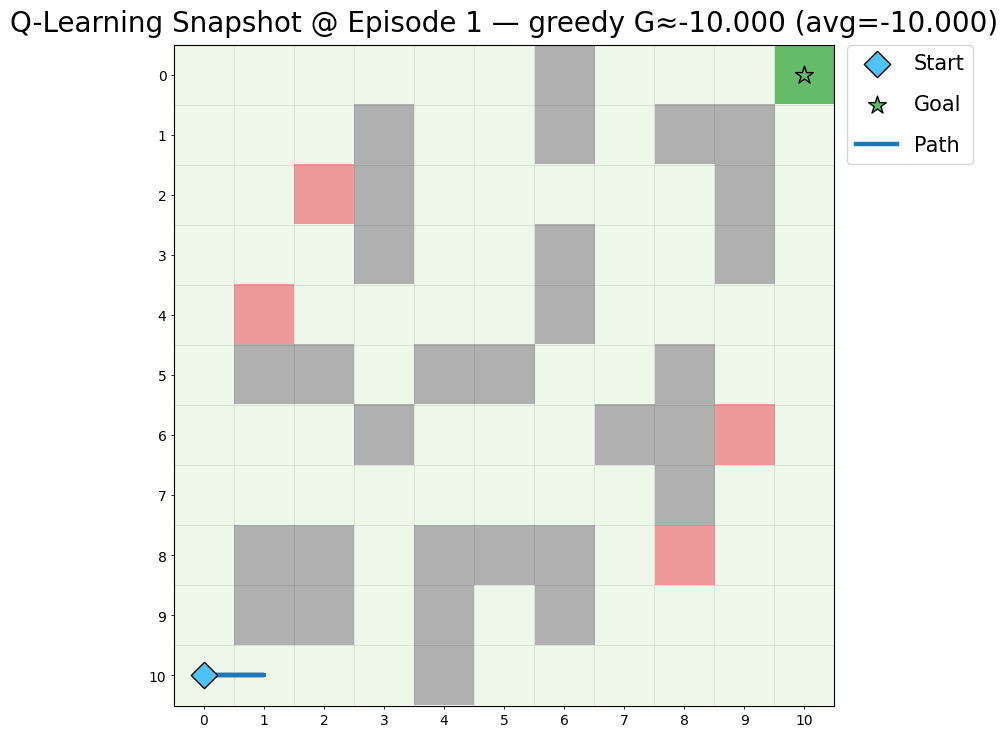

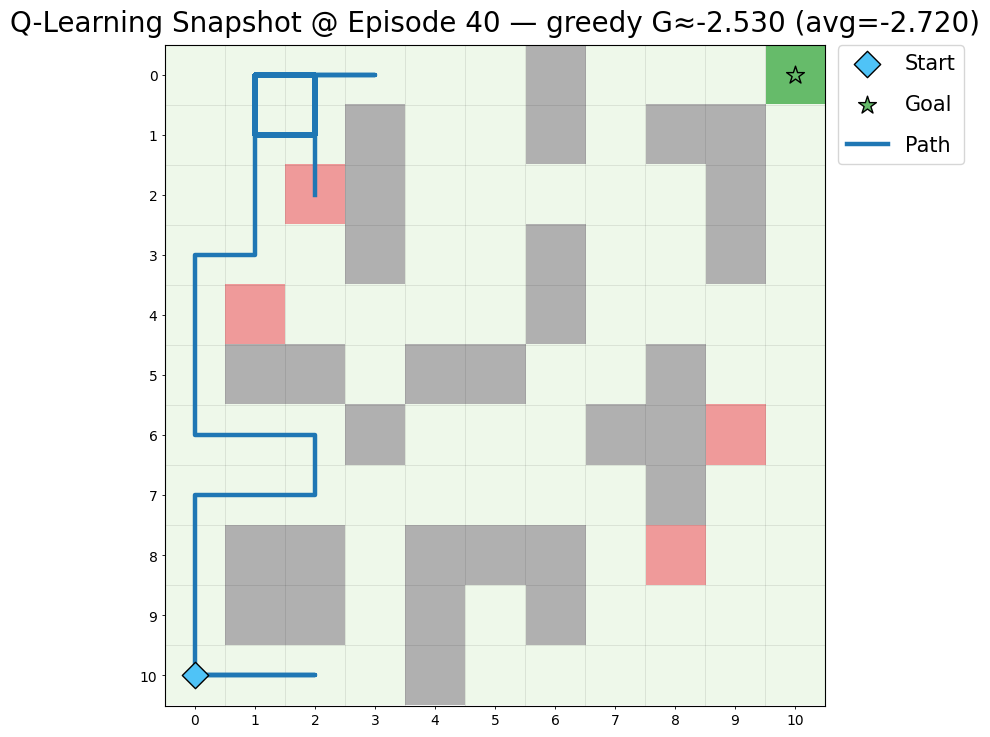

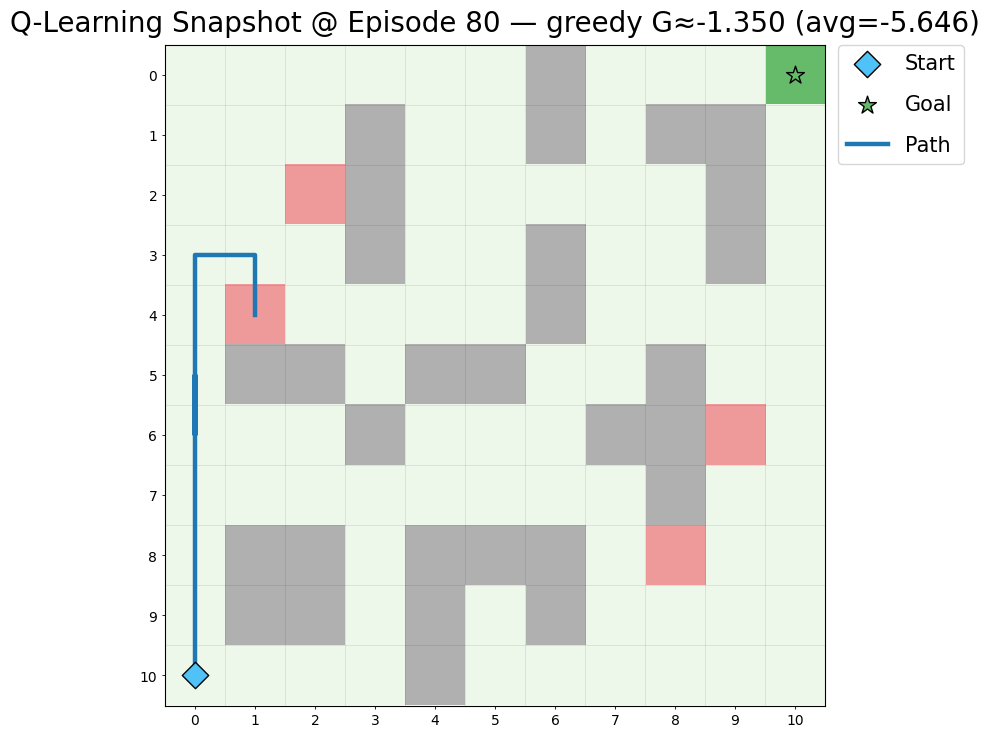

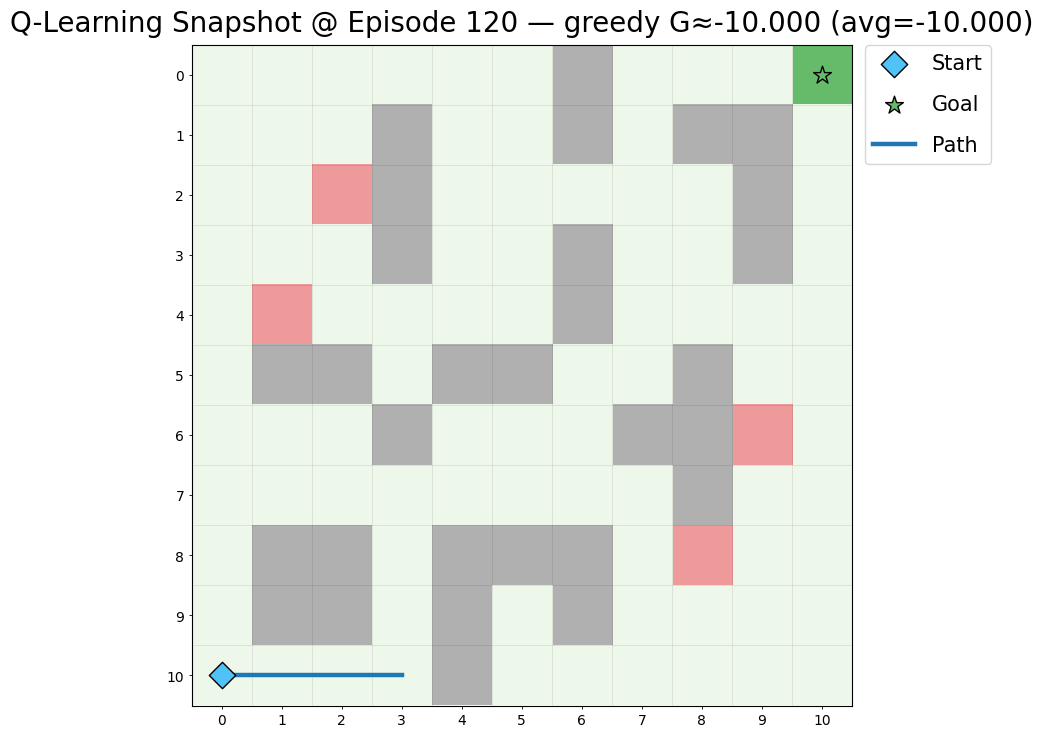

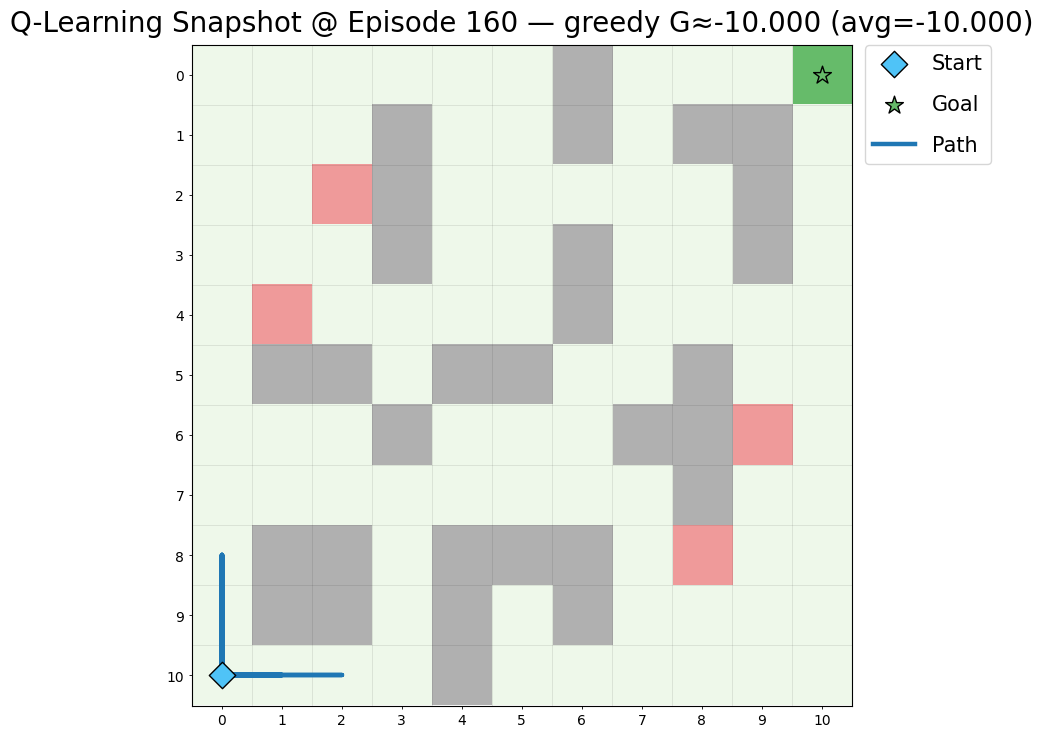

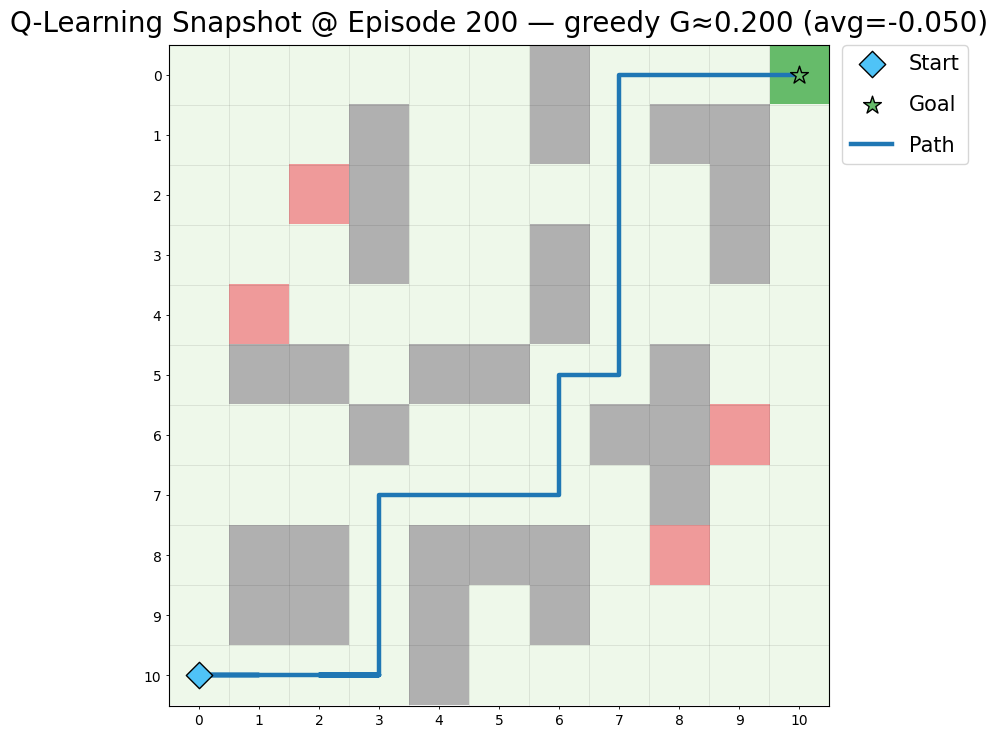

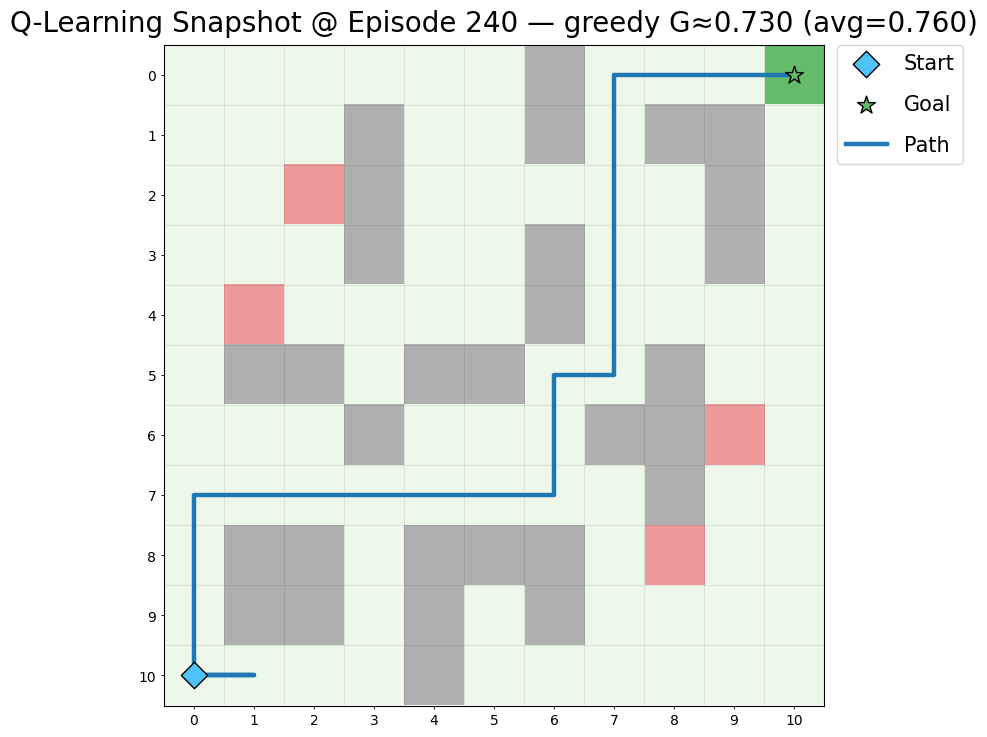

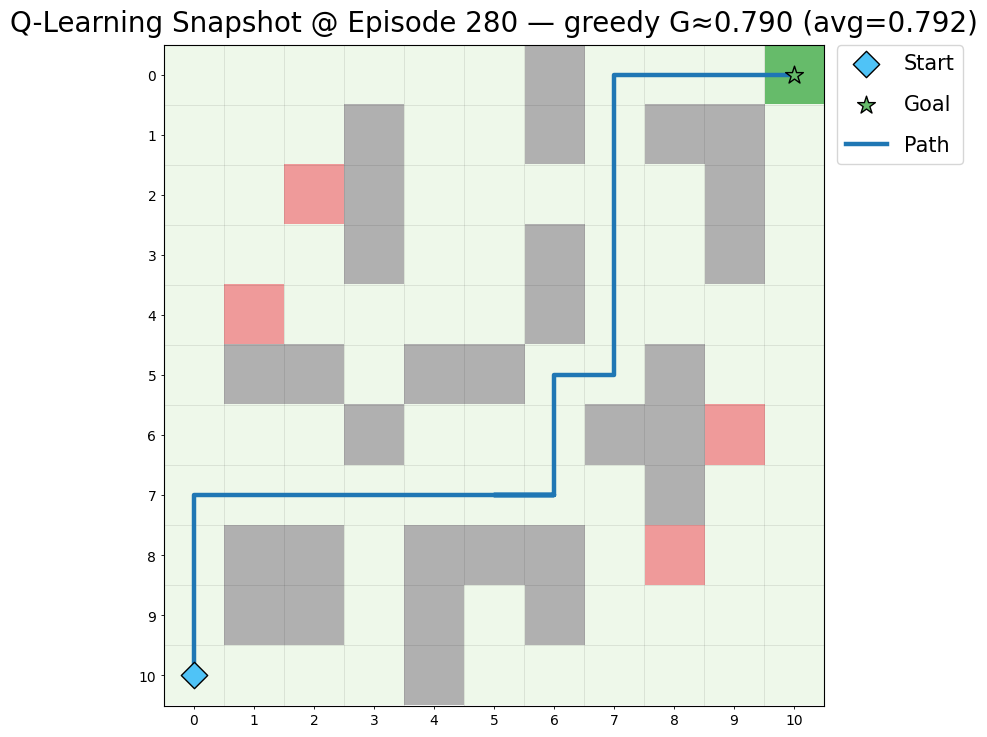

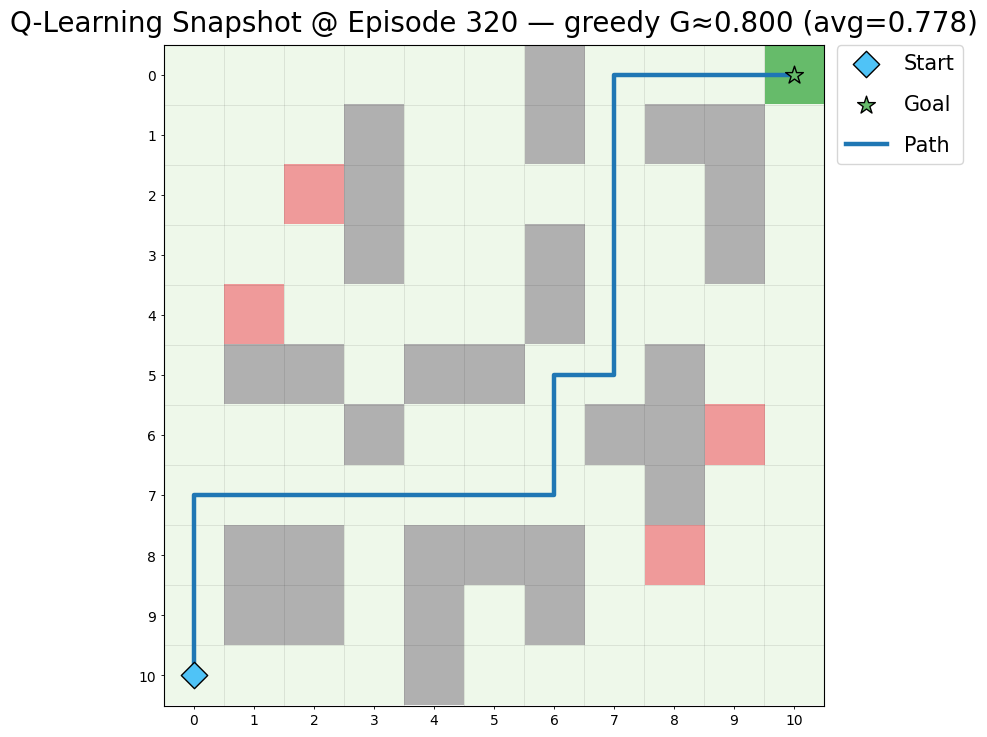

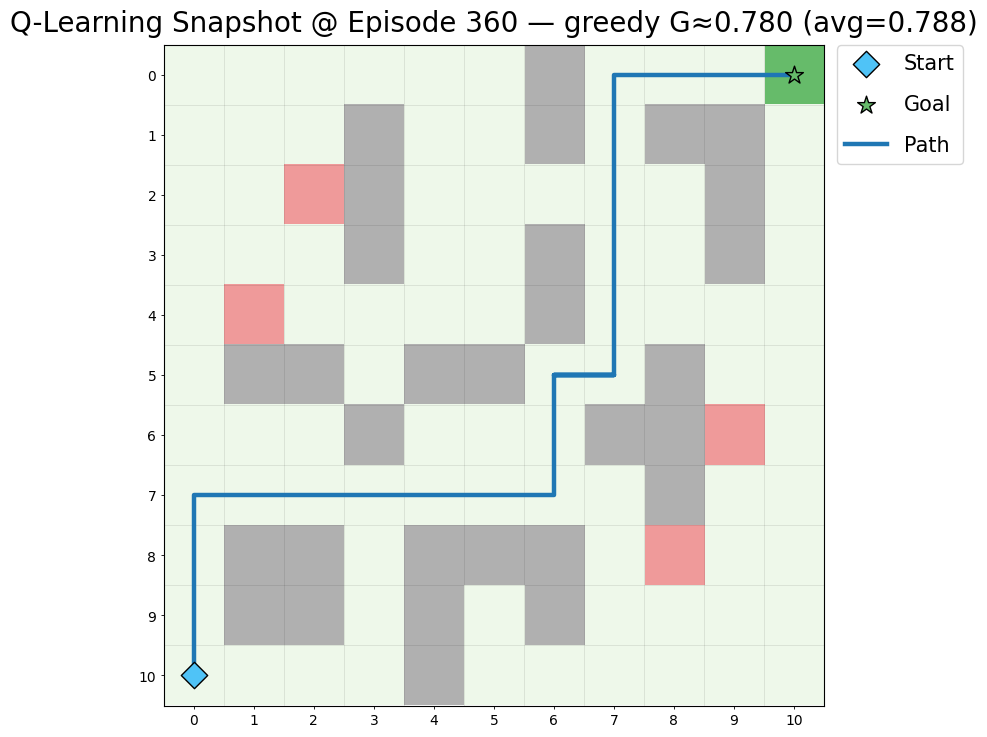

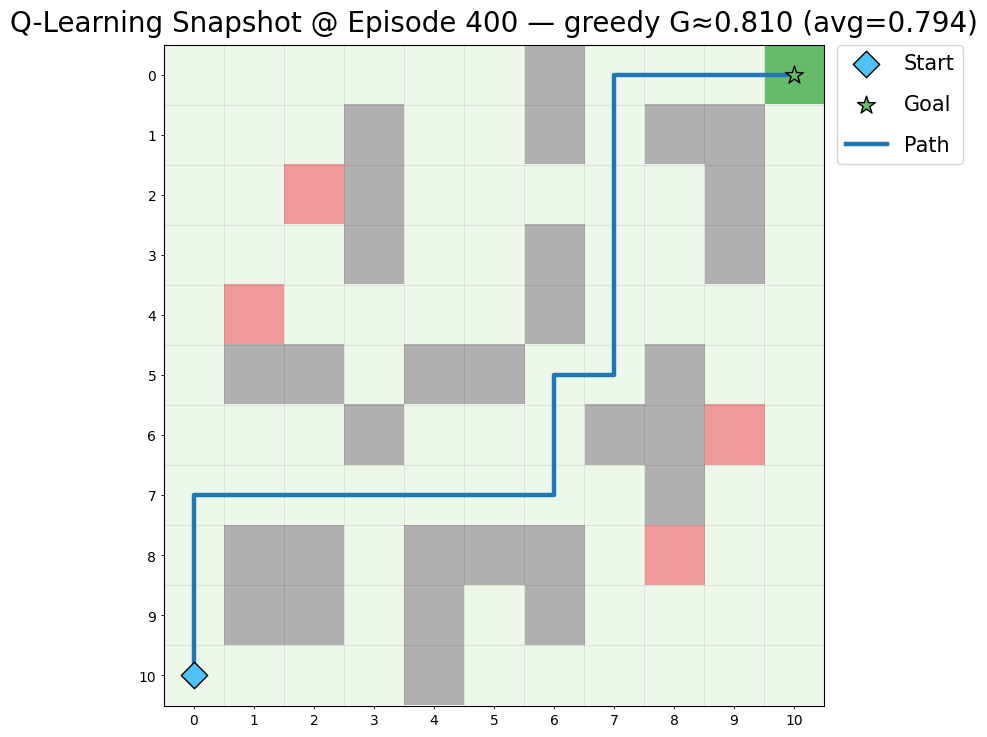

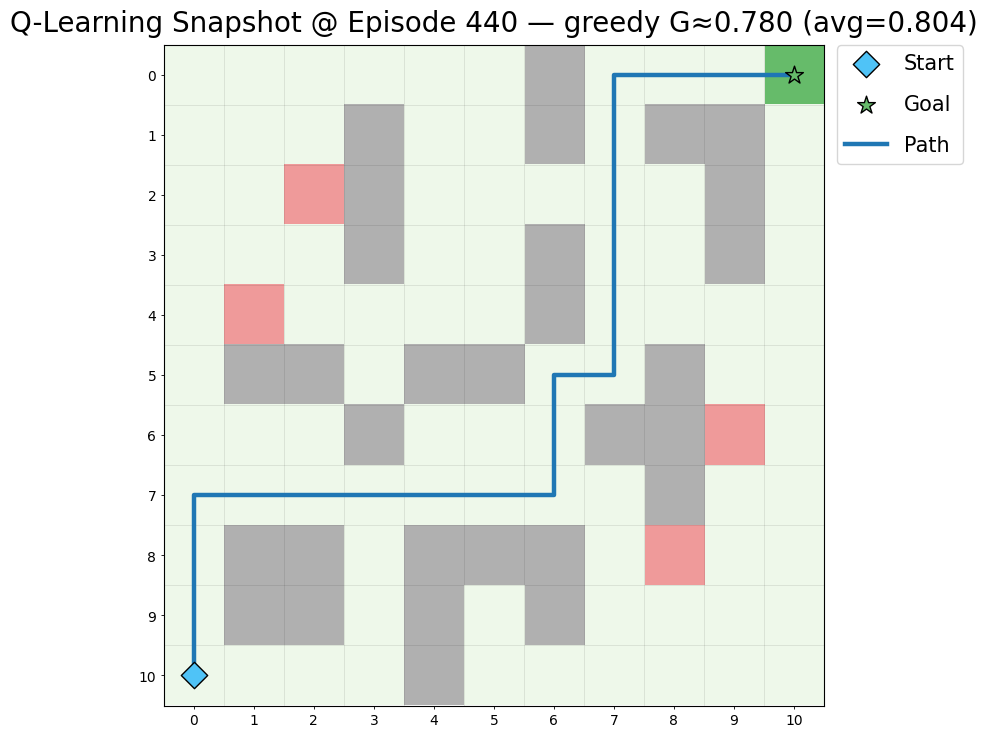

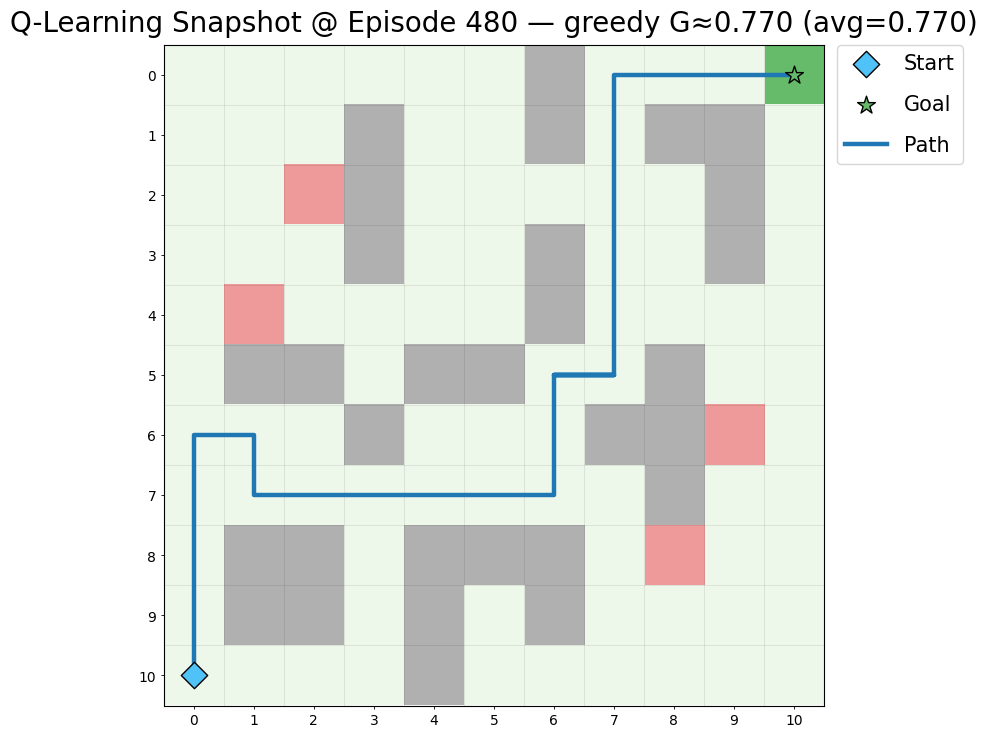

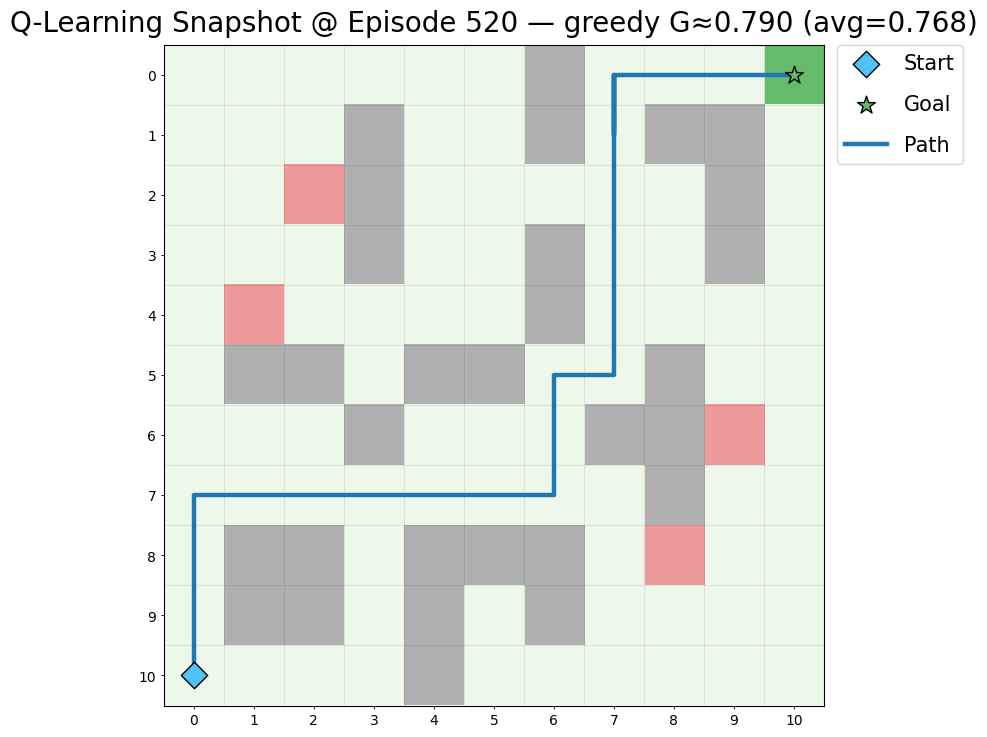

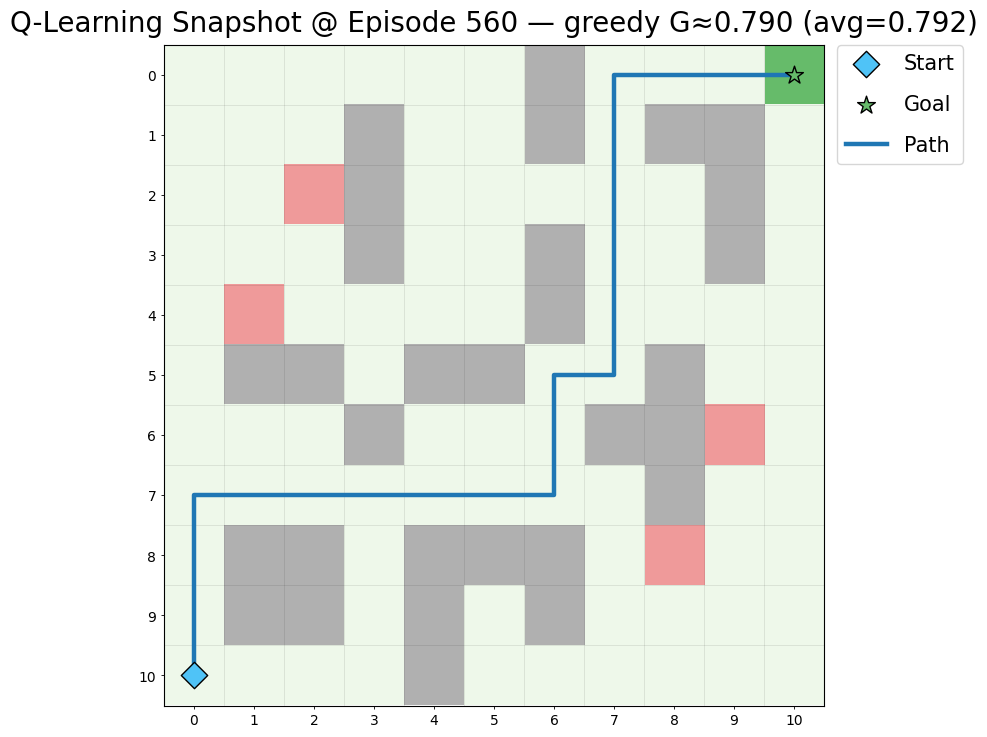

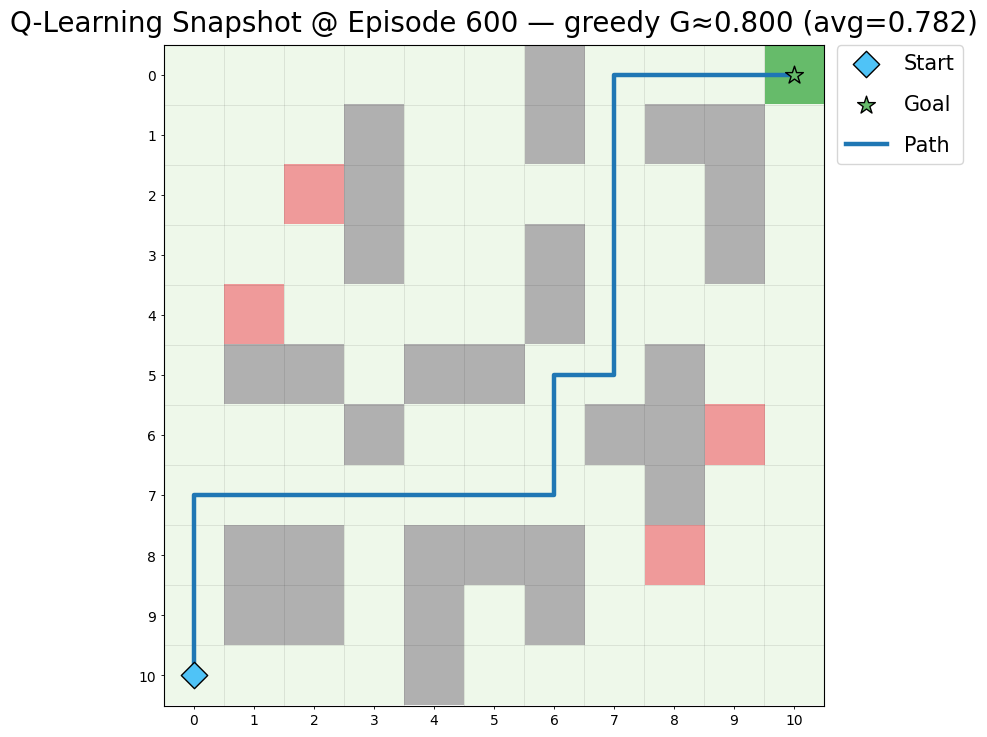

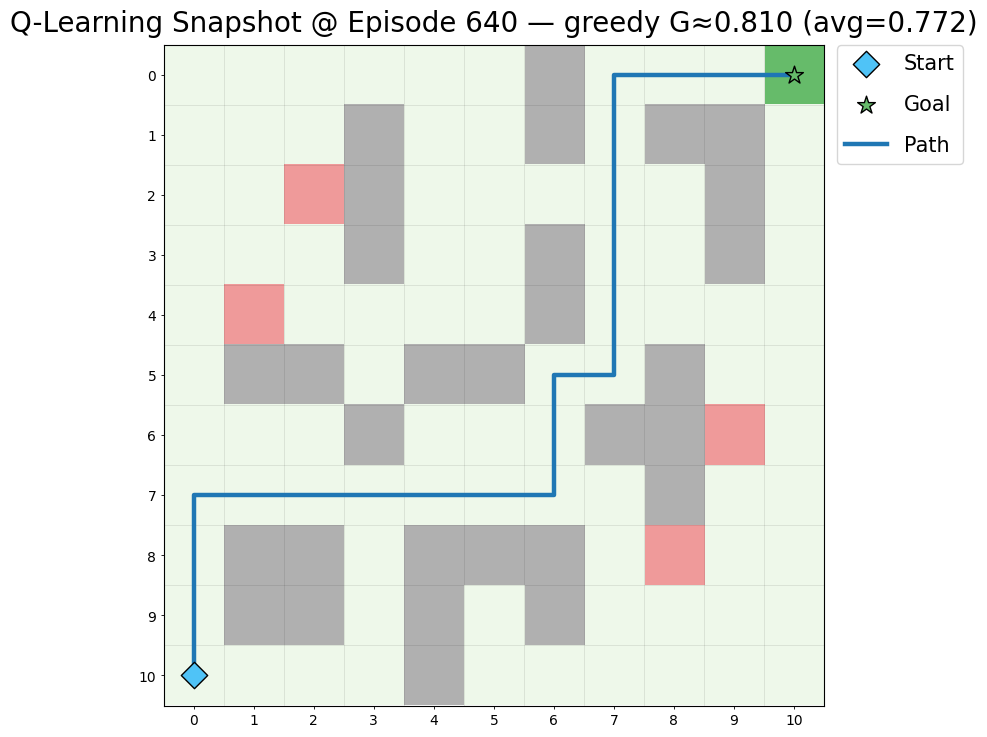

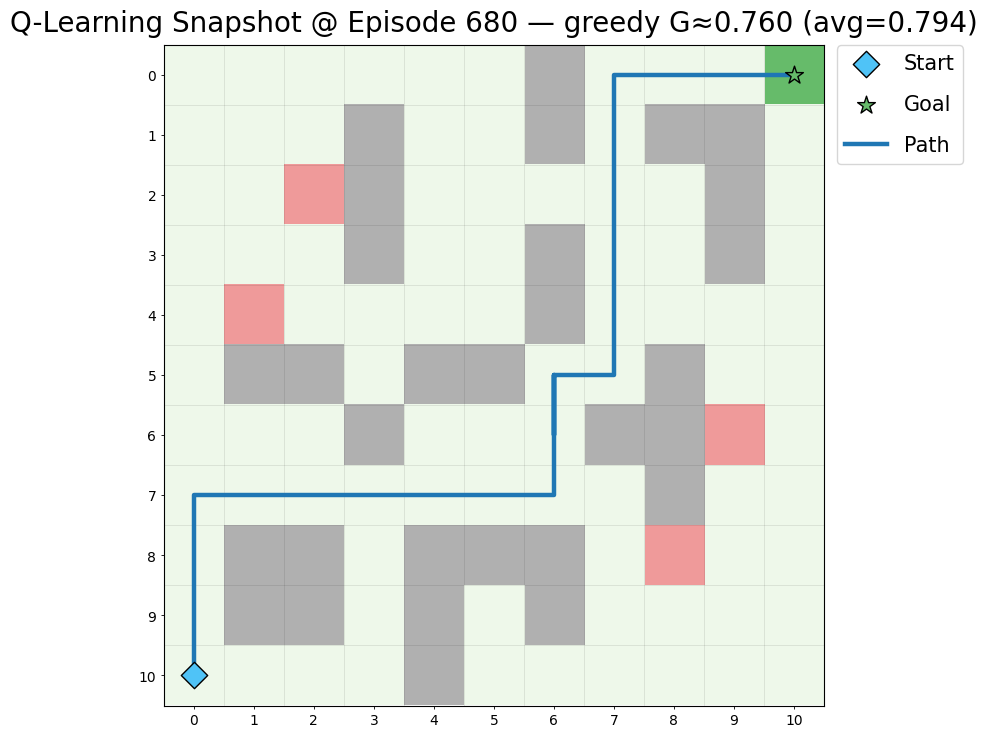

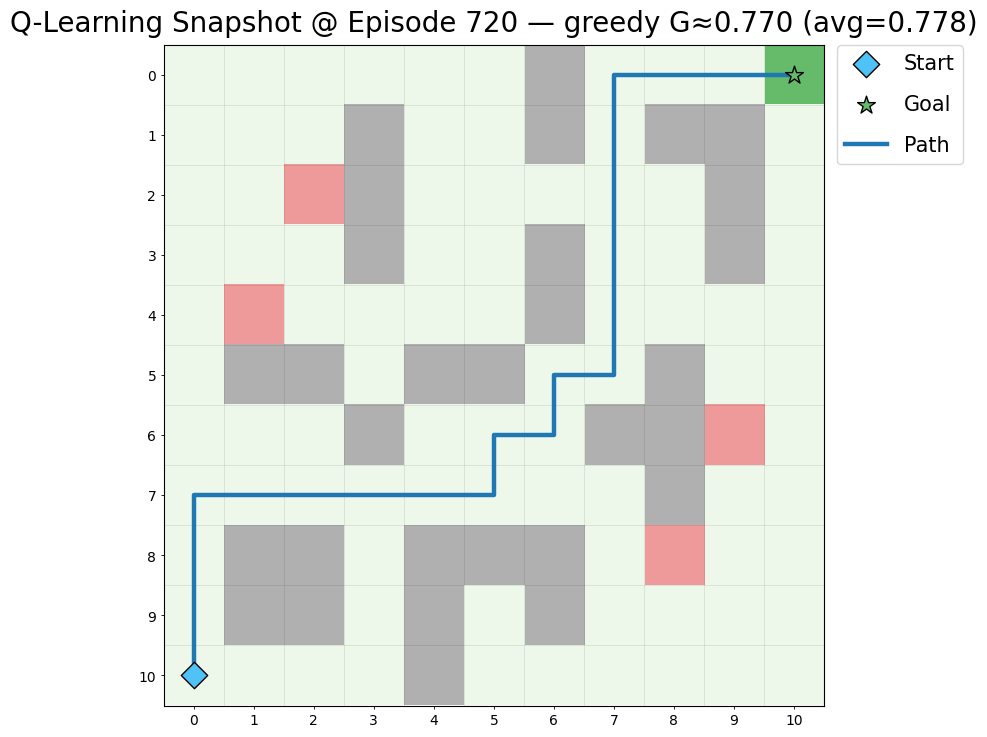

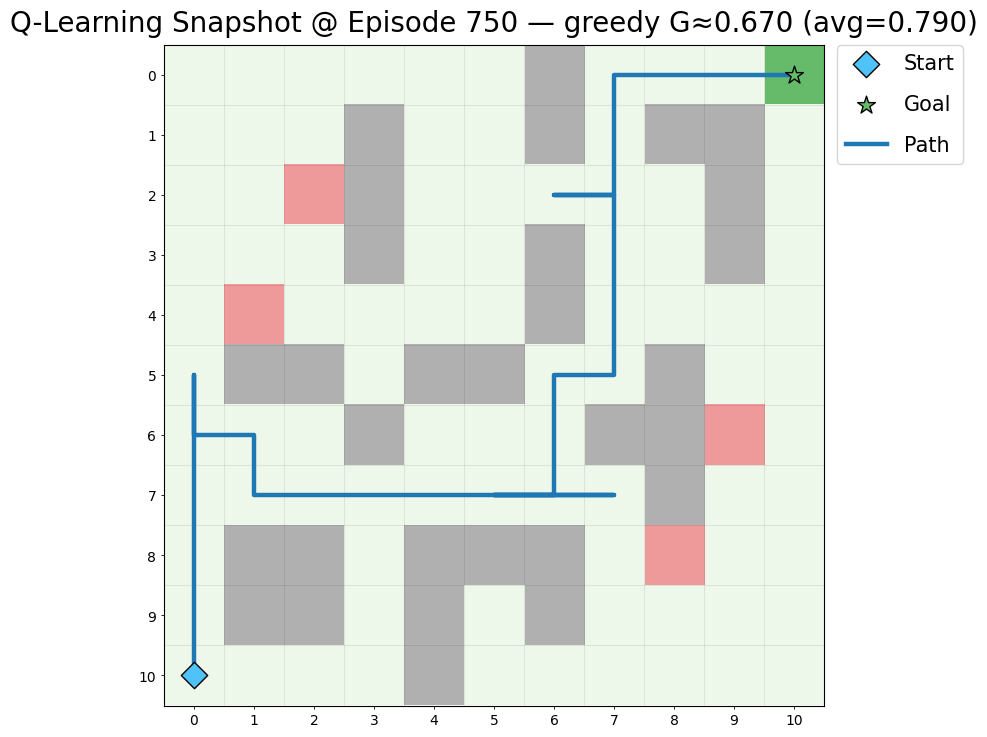

In [16]:
# Snapshots
for snap in logs["snapshots"]:
    ep = snap["episode"]
    Q_snap = snap["Q"]
    avg_ret = snap["avg_return"]

    # Run one greedy episode from this snapshot
    G_snap, traj_idx = run_greedy_episode(env, Q_snap, max_steps=cfg.max_steps)
    path_rc = idx_traj_to_rc_path(env, traj_idx)

    env.reset()
    env.render(
        path=path_rc,
        show_agent=False,
        title=f"Q-Learning Snapshot @ Episode {ep} — greedy G≈{G_snap:.3f} (avg={avg_ret:.3f})"
    )

## 6) Final Path
This section prints the last outcome from the algorithm, showing the "most" optimal output. It provides the average `result` and `steps` the agent took during the algorithm.

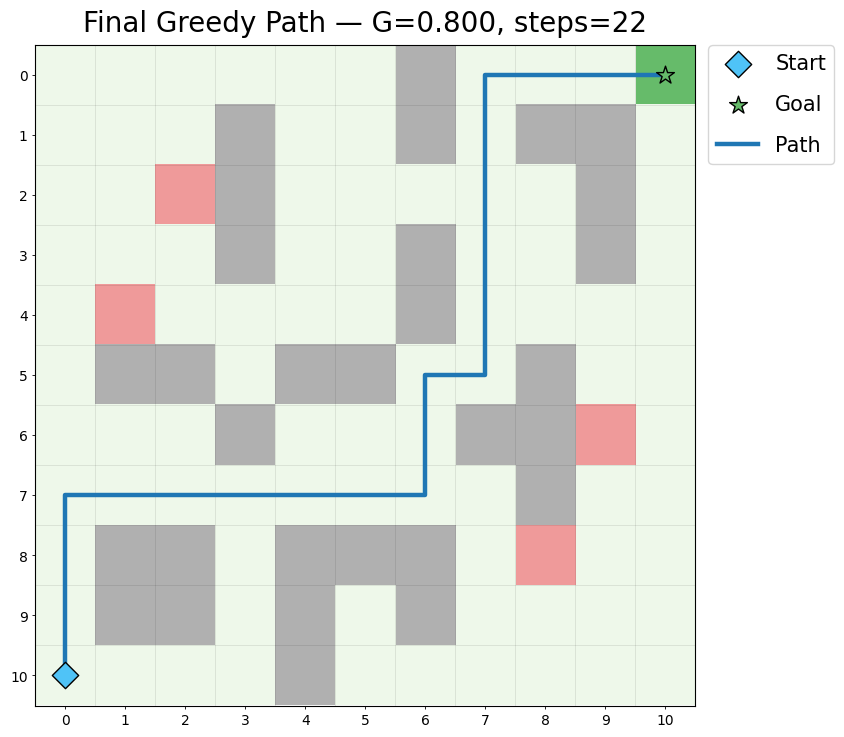

In [17]:
# Final Optimal Greedy Path
G_final, traj_final = run_greedy_episode(env, Q, max_steps=cfg.max_steps)
env.reset()
env.render(
    path=idx_traj_to_rc_path(env, traj_final),
    show_agent=False,
    title=f"Final Greedy Path — G={G_final:.3f}, steps={len(traj_final)}"
)

## 7) Policy / Value heatmap with arrows

Heat maps are used to visualize what is the trajectory that the agent took the most in order to find the "most" optimal greedy path.

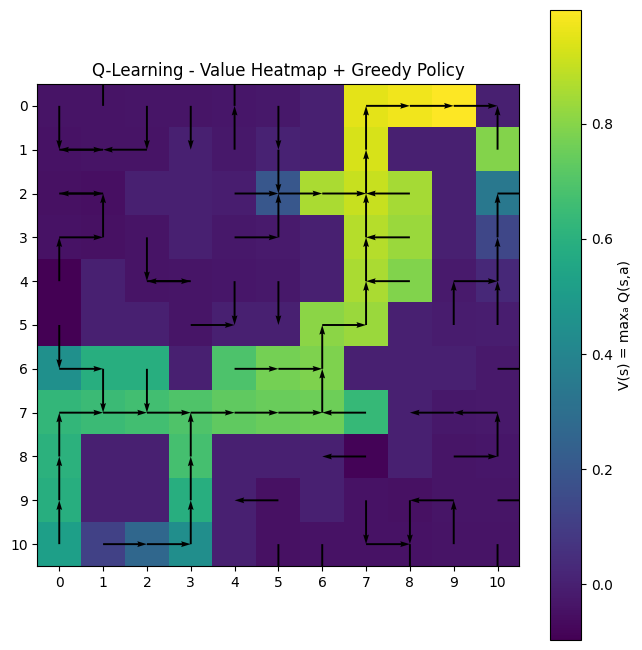

In [18]:
# Final Q_learning Visualization heatmap
plot_value_and_policy(env, Q, title="Q-Learning - Value Heatmap + Greedy Policy")

## Conclusion

The results demonstrate the core behavior of **Q_Learning**, gradual improvement in both cumulative return and path efficiency through repeated exploration and value updates.

* **Episodic Return:** Early episodes yield mostly negative returns because the agent explores randomly, often walking into pits, or looping aimlessly. Over time, as the Q-values converge and $\varepsilon$ decays, the agent learns to follow trajectories that reach the goal reliably, raising the return toward the optimal valud of = +1.
  
* **Episode Length:** The number of steps per pisode decreases sharply after roughly **100 - 150 episodes**. This shows that the agent no only finds successful routes but also learns to reach the goal faster by avoiding dead ends and unnecessary detours.

* **Final Policy and Value Function:** The heatmap of $V(s) = \max_{a'} \, Q(s, a)$ highlights high-value regions leading directly toward the goal (bright yellow). The greedy policy arrows form a coherent pathway from the start (bottom-left) to the goal (top-right), smoothly navigating around walls and pits, clear evidence of convergence to an optimal policy.

* **Greedy Path Visualization** The final path in the rendered GridWorld confirms this quantitative improvement: the agent travels efficiently from start to goal in only 23 steps, achieving a total return of = 0.79 despite stochastic wind effects.

---

<style>
    .button {
        background-color: #3b3b3b;
        color: white;
        padding: 25px 60px;
        border: none;
        border-radius: 12px;
        cursor: pointer;
        font-size: 30px;
        transition: background-color 0.3s ease;
    }

    .button:hover {
        background-color: #45a049;
        transform: scale(1.05);
    }
    
</style>

<div style=" text-align: center; margin-top:20px;">
    
  <a href="00_RL.ipynb">
    <button class="button">
      ⬅️ Prev: Project Details
    </button>
  </a>
  <span style="display:inline-block; width:200px;"></span>
  <a href="02_sarsa.ipynb">
    <button class="button">
      Next: SARSA ➡️
    </button>
  </a>
  
</div>
